In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:

# Load the dataset
file_path = 'WineQT.csv'
data = pd.read_csv(file_path)


In [5]:
# Data exploration
data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,6
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,8
9,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5,10


In [6]:
data=data.drop("Id",axis=1)

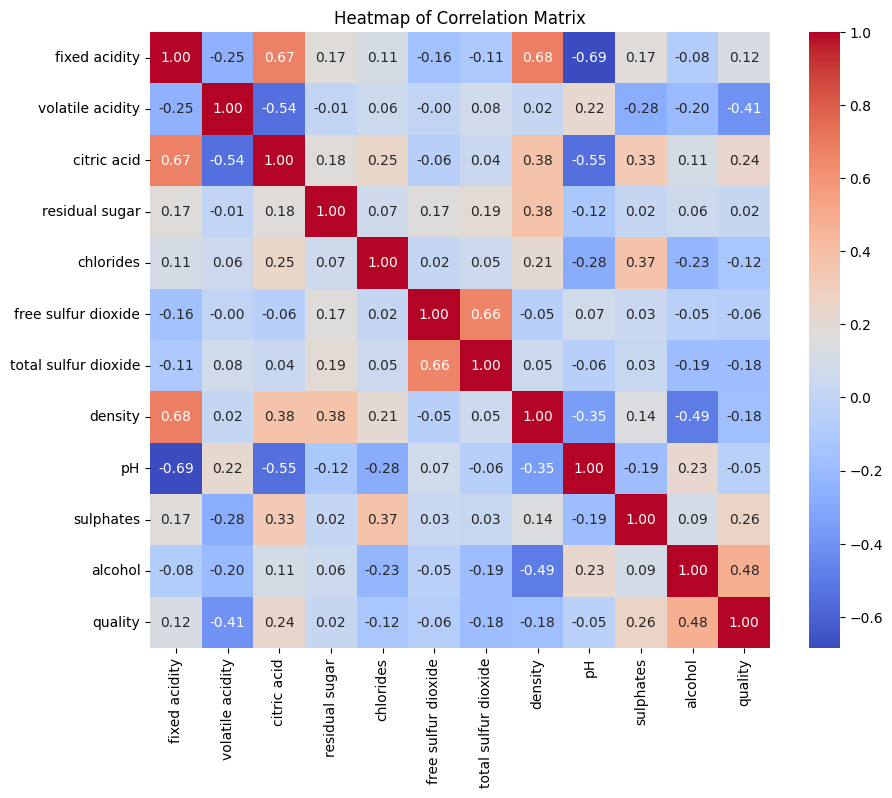

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Heatmap of Correlation Matrix')
plt.show()


In [17]:
from sklearn.feature_selection import RFE
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, y)
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Top features based on importance
top_features_rf = feature_importances['Feature'].head(7).tolist()

# Recursive Feature Elimination (RFE) with Logistic Regression
logreg_model = LogisticRegression(max_iter=10000)
rfe = RFE(logreg_model, n_features_to_select=7)
rfe.fit(X_scaled, y)
rfe_features = X.columns[rfe.support_].tolist()

top_features_rf, rfe_features

(['alcohol',
  'sulphates',
  'total sulfur dioxide',
  'volatile acidity',
  'density',
  'chlorides',
  'pH'],
 ['alcohol',
  'sulphates',
  'volatile acidity',
  'total sulfur dioxide',
  'density',
  'chlorides',
  'pH'])

In [8]:
top_features = ['alcohol', 'sulphates', 'volatile acidity', 'total sulfur dioxide', 'density', 'chlorides', 'pH']

In [9]:

# Split the data into features and target
X = data.drop('quality', axis=1)
y = data['quality']
X=X[top_features]

In [10]:

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [13]:

# Define a function to evaluate models
def evaluate_model_with_kfold(model, X, y):
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    return results

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    return accuracy, cm, cr


In [14]:

# Models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}


In [15]:
import warnings
warnings.filterwarnings("ignore")
# Evaluate models without SMOTE
results_without_smote = {}
for name, model in models.items():
    print(f'Evaluating {name} without SMOTE...')
    kfold_results = evaluate_model_with_kfold(model, X_train, y_train)
    accuracy, cm, cr = evaluate_model(model, X_train, X_test, y_train, y_test)
    results_without_smote[name] = {
        'kfold_results': kfold_results,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': cr
    }
    print(f'KFold Accuracy: {kfold_results.mean()}')
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{cm}')
    print(f'Classification Report:\n{cr}')


Evaluating Logistic Regression without SMOTE...
KFold Accuracy: 0.5831561880742209
Accuracy: 0.62882096069869
Confusion Matrix:
[[ 0  3  3  0  0]
 [ 1 68 25  2  0]
 [ 0 30 64  5  0]
 [ 0  2 12 12  0]
 [ 0  0  0  2  0]]
Classification Report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.66      0.71      0.68        96
           6       0.62      0.65      0.63        99
           7       0.57      0.46      0.51        26
           8       0.00      0.00      0.00         2

    accuracy                           0.63       229
   macro avg       0.37      0.36      0.36       229
weighted avg       0.61      0.63      0.62       229

Evaluating Random Forest without SMOTE...
KFold Accuracy: 0.6378430312856542
Accuracy: 0.6637554585152838
Confusion Matrix:
[[ 0  3  3  0  0]
 [ 0 73 23  0  0]
 [ 0 26 62 11  0]
 [ 0  0  9 17  0]
 [ 0  0  1  1  0]]
Classification Report:
              precision    reca

In [16]:
import warnings
warnings.filterwarnings("ignore")
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Evaluate models with SMOTE
results_with_smote = {}
for name, model in models.items():
    print(f'Evaluating {name} with SMOTE...')
    kfold_results = evaluate_model_with_kfold(model, X_train_smote, y_train_smote)
    accuracy, cm, cr = evaluate_model(model, X_train_smote, X_test, y_train_smote, y_test)
    results_with_smote[name] = {
        'kfold_results': kfold_results,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': cr
    }
    print(f'KFold Accuracy: {kfold_results.mean()}')
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{cm}')
    print(f'Classification Report:\n{cr}')


Evaluating Logistic Regression with SMOTE...
KFold Accuracy: 0.5736494252873563
Accuracy: 0.43231441048034935
Confusion Matrix:
[[ 0  0  0  0  0  0]
 [ 1  1  1  3  0  0]
 [ 8 12 51 20  2  3]
 [ 2 14 19 33 19 12]
 [ 0  1  1  5 12  7]
 [ 0  0  0  0  0  2]]
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.04      0.17      0.06         6
           5       0.71      0.53      0.61        96
           6       0.54      0.33      0.41        99
           7       0.36      0.46      0.41        26
           8       0.08      1.00      0.15         2

    accuracy                           0.43       229
   macro avg       0.29      0.42      0.27       229
weighted avg       0.57      0.43      0.48       229

Evaluating Random Forest with SMOTE...
KFold Accuracy: 0.8600454208379682
Accuracy: 0.5938864628820961
Confusion Matrix:
[[ 0  0  0  0  0  0]
 [ 0  0  3  2  1  0]
 [ 5  4 66 18  3